# Demonstrating Iris mesh concepts

Goals :
  * introduce mesh coordinates + connectivities
  * show real LFRic mesh structure on plots

In [1]:
import numpy as np
from pv_conversions import pv_from_lfric_cube

In [2]:
## TODO : remove later -- this bit is temporary, for initial testing with C48 data
from testdata_fetching import switch_data
switch_data(use_newer_smaller_c48_data=True)

In [3]:
from testdata_fetching import lfric_rh_singletime_2d
cube = lfric_rh_singletime_2d()
print(cube)

relative_humidity_at_screen_level / (1) (-- : 13824)
    Mesh coordinates:
        latitude                            x
        longitude                           x
    Mesh:
        name                            Topology data of 2D unstructured mesh
        location                        face
    Scalar coordinates:
        forecast_period                 21600 seconds
        forecast_reference_time         2021-03-24 00:00:00
        time                            2021-03-24 06:00:00
    Cell methods:
        point                           time
    Attributes:
        Conventions                     'CF-1.7'
        description                     'Created by xios'
        interval_operation              '6 h'
        interval_write                  '6 h'
        online_operation                'instant'
        title                           'Created by xios'


In [4]:
# Snapshot the original data range -- this is useful below
data_min, data_max = cube.data.min(), cube.data.max()
data_range = data_max - data_min

In [5]:
# Calculate the coordinates of a cubesphere corner
x_corner = 45.0
y_corner = np.rad2deg(np.arctan(1.0 / np.sqrt(2)))
y_corner, x_corner

(35.264389682754654, 45.0)

In [6]:
# Get node coordinates from the mesh
x_nodes_coord = cube.mesh.coord(axis='x', include_nodes=True)
y_nodes_coord = cube.mesh.coord(axis='y', include_nodes=True)
x_nodes_coord

<AuxCoord: longitude / (degrees)  <lazy>  shape(13826,)>

In [7]:
# Find the number of the node nearest the cubesphere corner
xx = x_nodes_coord.points
yy = y_nodes_coord.points
xy_dists = (xx -  x_corner) ** 2 + (yy - y_corner) ** 2
closest = np.min(xy_dists)
i_node_nearest_corner = np.argmin(xy_dists)

# show the results
print(
    'corner index :',
    i_node_nearest_corner
)
print('Some corner-distances around the corner node.. : ')
print('   ', xy_dists[i_node_nearest_corner - 2:i_node_nearest_corner + 3]
)

corner index : 97
Some corner-distances around the corner node.. : 
    [4.2551804e+00 3.0581756e+00 0.0000000e+00 8.1119761e+03 7.7729966e+03]


In [8]:
# Now find the faces which touch that corner
# (spoiler alert : if we specced the corner right, there are probably 3 of them)
face_nodes = cube.mesh.face_node_connectivity.indices
assert face_nodes.ndim == 2 and face_nodes.shape[1] == 4

In [9]:
face_on_corner = np.any(face_nodes == i_node_nearest_corner, axis=1)
corner_faces = np.where(face_on_corner)[0]
print('corner face indices :', corner_faces)

corner face indices : [   47  2304 11472]


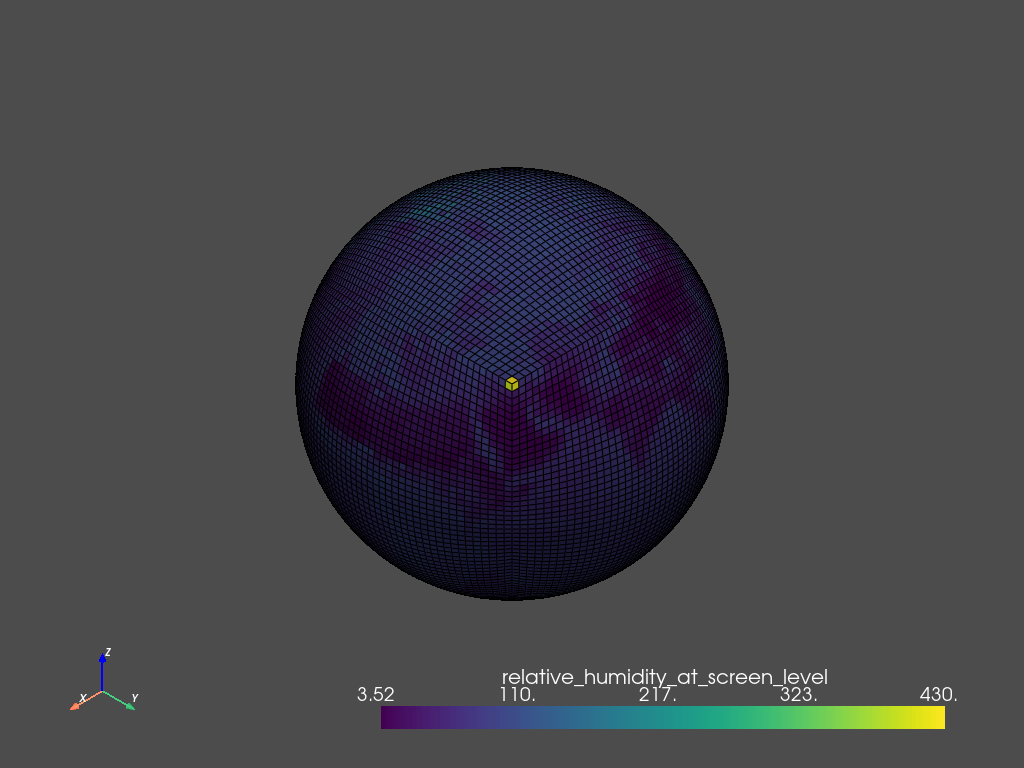

In [10]:
# Go back to the cube data, "mark" those faces visibly, and display
marks = data_max + data_range * np.array([1.2, 1.3, 1.4])
cube.data[corner_faces] = marks

# Plot the cube
pv = pv_from_lfric_cube(cube)
pv.plot(show_edges=True, jupyter_backend='static')

---

Now "expand" this face selection outwards   
-- to include all the faces adjacent to these ones ...

In [11]:
# **First** find all points which are corners of those faces
extended_points = cube.mesh.face_node_connectivity[corner_faces].indices
extended_points

masked_array(
  data=[[   94,    96,    97,    95],
        [   96,  2401,  2402,    97],
        [   95,    97,  2402, 11570]],
  mask=False,
  fill_value=999999,
  dtype=int32)

In [12]:
# Tidy to get sorted + unique point indices
extended_points = sorted(set(extended_points.flatten()))
print(extended_points)

[94, 95, 96, 97, 2401, 2402, 11570]


In [13]:
# ... **Then** find all faces which use those points (as before)
extended_faces = []
for i_point in extended_points:
    face_touches_point = np.any(face_nodes == i_point, axis=1)
    extended_faces.extend(np.where(face_touches_point)[0])

# tidy for sorted + unique, again
extended_faces = sorted(set(extended_faces))
print(extended_faces)

[46, 47, 94, 95, 2304, 2305, 2352, 2353, 11424, 11425, 11472, 11473]


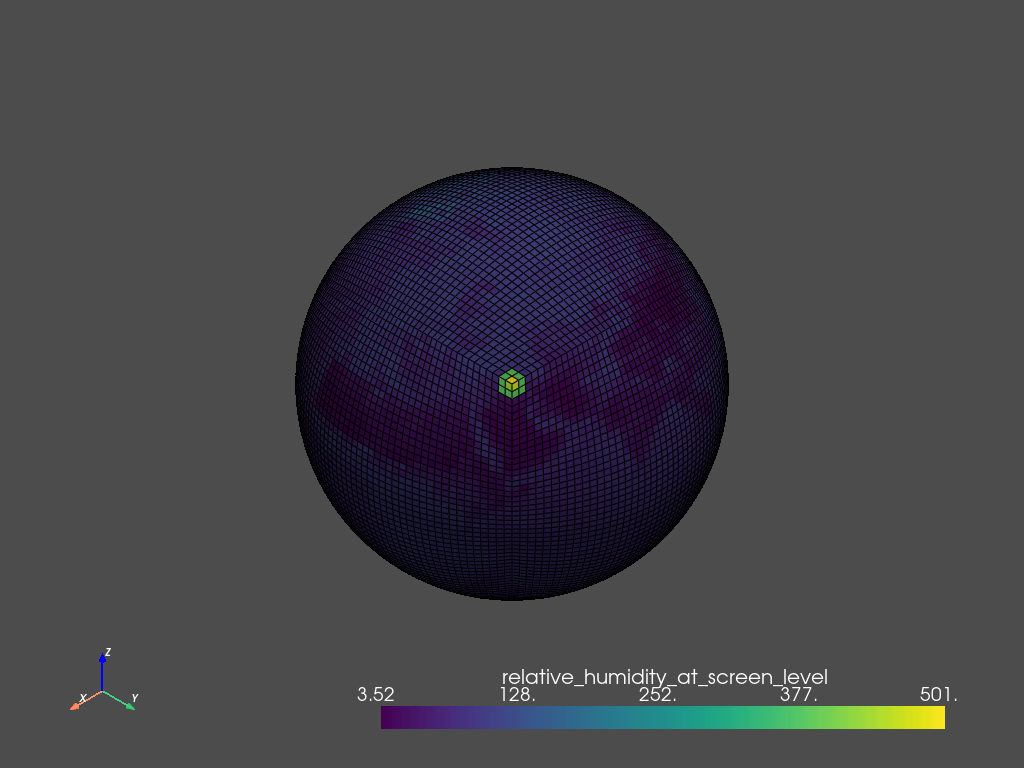

In [14]:
# Mark all those faces too, distinguishing "outer" and "inner", and re-plot
cube.data[extended_faces] = data_max + data_range * 1.1
cube.data[corner_faces] = data_max + data_range * np.array([1.4, 1.6, 1.8])
pv = pv_from_lfric_cube(cube)
pv.plot(show_edges=True, jupyter_backend='static')

In [15]:
# Follow-on : take the above info + produce a plot of the (numbered) nodes + faces of
# a tiny section of the LFRic mesh, for use as a diagram in Sec#02

In [16]:
# How many faces ?
len(extended_faces)

12

In [17]:
# some random face values ...
import numpy.random
numpy.random.seed(seed=1234)
face_values = np.random.uniform(0, 1.0, 12)
face_values

array([0.19151945, 0.62210877, 0.43772774, 0.78535858, 0.77997581,
       0.27259261, 0.27646426, 0.80187218, 0.95813935, 0.87593263,
       0.35781727, 0.50099513])

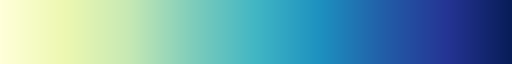

In [18]:
# convert to colours
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as mcm

cmap = mcm.get_cmap('YlGnBu')
cmap

In [19]:
import matplotlib.colors

In [20]:
cols = matplotlib.colors.get_named_colors_mapping().keys()
print('\n'.join(x for x in cols if 'purp' in x))

xkcd:warm purple
xkcd:blue with a hint of purple
xkcd:purpley grey
xkcd:purply
xkcd:eggplant purple
xkcd:baby purple
xkcd:rich purple
xkcd:vivid purple
xkcd:darkish purple
xkcd:dirty purple
xkcd:plum purple
xkcd:purple/blue
xkcd:lightish purple
xkcd:purple/pink
xkcd:purple brown
xkcd:vibrant purple
xkcd:purpley
xkcd:ugly purple
xkcd:grape purple
xkcd:purplish brown
xkcd:purpleish pink
xkcd:midnight purple
xkcd:muted purple
xkcd:purple red
xkcd:purply pink
xkcd:dusky purple
xkcd:blue/purple
xkcd:soft purple
xkcd:purpley pink
xkcd:easter purple
xkcd:purplish red
xkcd:pink/purple
xkcd:brownish purple
xkcd:very dark purple
xkcd:very light purple
xkcd:purplish grey
xkcd:bluey purple
xkcd:purpleish
xkcd:purply blue
xkcd:purpleish blue
xkcd:red purple
xkcd:lighter purple
xkcd:medium purple
xkcd:purpley blue
xkcd:hot purple
xkcd:electric purple
xkcd:purple grey
xkcd:faded purple
xkcd:barney purple
xkcd:purplish
xkcd:dusty purple
xkcd:dull purple
xkcd:grey purple
xkcd:purple pink
xkcd:pinky pur

In [21]:
for x in face_values:
    print(x, cmap(0.5 * x))

0.1915194503788923 (0.9468512110726643, 0.9793310265282583, 0.7328719723183391, 1.0)
0.6221087710398319 (0.6453056516724337, 0.8611918492887352, 0.7190157631680123, 1.0)
0.4377277390071145 (0.8166243752402922, 0.9280276816608997, 0.7030219146482123, 1.0)
0.7853585837137692 (0.46466743560169166, 0.7915417147251057, 0.7381776239907727, 1.0)
0.7799758081188035 (0.4722952710495963, 0.7943713956170704, 0.7370703575547866, 1.0)
0.2725926052826416 (0.9194771241830065, 0.9686274509803922, 0.6949019607843137, 1.0)
0.2764642551430967 (0.914801999231065, 0.9667820069204152, 0.6952710495963091, 1.0)
0.8018721775350193 (0.44941176470588234, 0.7858823529411765, 0.7403921568627451, 1.0)
0.9581393536837052 (0.2968550557477894, 0.729288735101884, 0.7625374855824683, 1.0)
0.8759326347420947 (0.3731334102268358, 0.7575855440215302, 0.7514648212226067, 1.0)
0.35781726995786667 (0.8680507497116494, 0.9483275663206459, 0.698961937716263, 1.0)
0.5009951255234587 (0.7781776239907728, 0.9128642829680892, 0.706

In [22]:
# Repeat the extended-points search to get all points in extended faces
ex2_points = cube.mesh.face_node_connectivity[extended_faces].indices
ex2_points = sorted(set(ex2_points.flatten()))
print(ex2_points)

[92, 93, 94, 95, 96, 97, 144, 145, 146, 2401, 2402, 2403, 2404, 2497, 2498, 11523, 11524, 11570, 11571]


In [23]:
print(min(xx[ex2_points]), max(xx[ex2_points]))
print(min(yy[ex2_points]), max(yy[ex2_points]))

41.25 48.75
31.803713 38.879257


In [24]:
len(extended_faces)

12

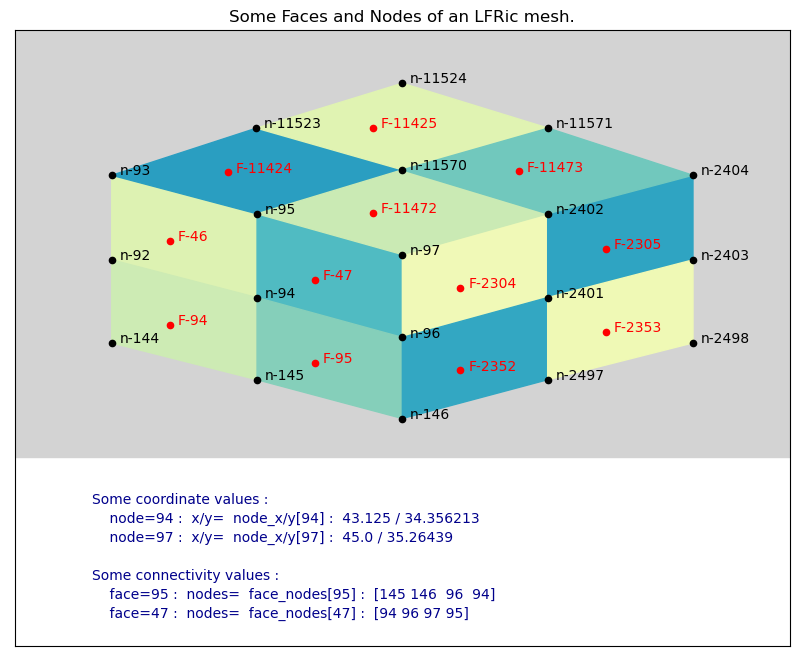

In [25]:
numpy.random.seed(seed=12)
face_values = np.random.uniform(0, 1.0, 12)

fig = plt.figure(figsize=(10,8))
ax = plt.axes()
ax.set_xlim((40, 50))
ax.set_ylim((27, 40))
ax.fill([40, 50, 50, 40, 40], [31, 31, 40, 40, 31], color='lightgray')

dotsize = 4.5

# Label all the corners with red text
for i_pt in ex2_points:
    x, y = xx[i_pt], yy[i_pt]
    plt.plot([x], [y], 'o', color='black', markersize=dotsize)
    plt.text(x + 0.1, y, 'n-' + str(i_pt), color='black')

# color all the faces
for i_col, i_fc in enumerate(extended_faces):
    nodes = list(face_nodes[i_fc])
    face_xx, face_yy = xx[nodes], yy[nodes]
    points_x = list(face_xx) + [face_xx[0]]
    points_y = list(face_yy) + [face_yy[0]]
    color = cmap(0.1 + 0.5 * face_values[i_col])
    plt.fill(points_x, points_y, color=color)
    xav, yav = np.mean(points_x), np.mean(points_y)
    plt.plot(xav, yav, 'o', color='red', markersize=dotsize)
    plt.text(xav+0.1, yav, 'F-' + str(i_fc), color='red')

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# print-lines
lines = []
lines.append('Some coordinate values :')
lines.append(
    '    node=94 :  x/y=  node_x/y[94] :  ' +
    str(x_nodes_coord.points[94]) +
    ' / ' + str(y_nodes_coord.points[94])
)
lines.append(
    '    node=97 :  x/y=  node_x/y[97] :  ' +
    str(x_nodes_coord.points[97]) +
    ' / ' + str(y_nodes_coord.points[97])
)
lines.append('')
lines.append('Some connectivity values :')
lines.append('    face=95 :  nodes=  face_nodes[95] :  ' + str(face_nodes[95]))
lines.append('    face=47 :  nodes=  face_nodes[47] :  ' + str(face_nodes[47]))
y_space = 0.4
for i_line, line in enumerate(lines):
    y = 30. - i_line * y_space
    plt.text(41., y, line, color='darkblue')
    
plt.title('Some Faces and Nodes of an LFRic mesh.')
plt.savefig('LFRic_mesh.svg')
plt.show()

In [26]:
print('Example coordinate + connectivity values ...')
print('')
print(
    'node=94 x//y= node_x//y[94] = ',
    x_nodes_coord.points[94],
    ' //', y_nodes_coord.points[94]
)
print(
    'node=95 x//y= node_x//y[95] = ',
    x_nodes_coord.points[95],
    ' //', y_nodes_coord.points[95]
)
print('')
print('face=46 nodes=face_nodes[46] = ', face_nodes[46])
print('face=46 nodes=face_nodes[46] = ', face_nodes[46])


Example coordinate + connectivity values ...

node=94 x//y= node_x//y[94] =  43.125  // 34.356213
node=95 x//y= node_x//y[95] =  43.125  // 36.124363

face=46 nodes=face_nodes[46] =  [92 94 95 93]
face=46 nodes=face_nodes[46] =  [92 94 95 93]


In [27]:
cube.mesh.node_coords[0]

<AuxCoord: longitude / (degrees)  [ -45. , -43.125, ..., -133.117, -135. ]  shape(13826,)>